In [1]:
!pip install neat-python

     |████████████████████████████████| 51kB 3.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from __future__ import print_function
import os
import pandas as pd
import numpy as np
import sys 
import os
import math
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from IPython.display import clear_output

In [4]:
import sys
import neat
sys.path.insert(0,'/content/drive/My Drive/2. Adelaide Uni/Research Project/Evolutionary Models/Imports')
from UpperBoundCalculator import UpperBoundCalculator
from StatisticsReporter import StatisticsReporter
from Reporting import StdOutReporter
from Reporting import ReporterSet
from Reporting import BaseReporter



In [5]:
# Uploading the saved model state
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def create_mount_pydrive():
    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    u_drive = GoogleDrive(gauth)
    return u_drive


In [6]:
# upload_drive = create_mount_pydrive()

In [7]:
"""Implements the core evolution algorithm."""
from neat.math_util import mean
from neat.six_util import iteritems, itervalues


class CompleteExtinctionException(Exception):
    pass

class Population(object):
    """
    This class implements the core evolution algorithm:
        1. Evaluate fitness of all genomes.
        2. Check to see if the termination criterion is satisfied; exit if it is.
        3. Generate the next generation from the current population.
        4. Partition the new generation into species based on genetic similarity.
        5. Go to 1.
    """

    def __init__(self, config, initial_state=None):
        self.reporters = ReporterSet()
        self.config = config
        stagnation = config.stagnation_type(config.stagnation_config, self.reporters)
        self.reproduction = config.reproduction_type(config.reproduction_config,
                                                     self.reporters,
                                                     stagnation)
        if config.fitness_criterion == 'max':
            self.fitness_criterion = max
        elif config.fitness_criterion == 'min':
            self.fitness_criterion = min
        elif config.fitness_criterion == 'mean':
            self.fitness_criterion = mean
        elif not config.no_fitness_termination:
            raise RuntimeError(
                "Unexpected fitness_criterion: {0!r}".format(config.fitness_criterion))

        if initial_state is None:
            # Create a population from scratch, then partition into species.
            self.population = self.reproduction.create_new(config.genome_type,
                                                           config.genome_config,
                                                           config.pop_size)
            self.species = config.species_set_type(config.species_set_config, self.reporters)
            self.generation = 0
            self.species.speciate(config, self.population, self.generation)
        else:
            self.population, self.species, self.generation = initial_state

        self.best_genome = None

    def add_reporter(self, reporter):
        self.reporters.add(reporter)

    def remove_reporter(self, reporter):
        self.reporters.remove(reporter)

    def run(self, fitness_function, n=None):
        """
        Runs NEAT's genetic algorithm for at most n generations.  If n
        is None, run until solution is found or extinction occurs.

        The user-provided fitness_function must take only two arguments:
            1. The population as a list of (genome id, genome) tuples.
            2. The current configuration object.

        The return value of the fitness function is ignored, but it must assign
        a Python float to the `fitness` member of each genome.

        The fitness function is free to maintain external state, perform
        evaluations in parallel, etc.

        It is assumed that fitness_function does not modify the list of genomes,
        the genomes themselves (apart from updating the fitness member),
        or the configuration object.
        """

        if self.config.no_fitness_termination and (n is None):
            raise RuntimeError("Cannot have no generational limit with no fitness termination")

        k = 0
        while n is None or k < n:
            k += 1

            self.reporters.start_generation(self.generation)

            # Evaluate all genomes using the user-provided function.
            fitness_function(list(iteritems(self.population)), self.config)

            # Gather and report statistics.
            best = None
            for g in itervalues(self.population):
                if best is None or g.fitness > best.fitness:
                    best = g
            self.reporters.post_evaluate(self.config, self.population, self.species, best)

            # Track the best genome ever seen.
            if self.best_genome is None or best.fitness > self.best_genome.fitness:
                self.best_genome = best

            if not self.config.no_fitness_termination:
                # End if the fitness threshold is reached.
                fv = self.fitness_criterion(g.fitness for g in itervalues(self.population))
                if fv >= self.config.fitness_threshold:
                    self.reporters.found_solution(self.config, self.generation, best)
                    break

            # Create the next generation from the current generation.
            self.population = self.reproduction.reproduce(self.config, self.species,
                                                          self.config.pop_size, self.generation)

            # Check for complete extinction.
            if not self.species.species:
                self.reporters.complete_extinction()

                # If requested by the user, create a completely new population,
                # otherwise raise an exception.
                if self.config.reset_on_extinction:
                    self.population = self.reproduction.create_new(self.config.genome_type,
                                                                   self.config.genome_config,
                                                                   self.config.pop_size)
                else:
                    raise CompleteExtinctionException()

            # Divide the new population into species.
            self.species.speciate(self.config, self.population, self.generation)
            upload_drive = create_mount_pydrive()

            self.reporters.end_generation(self.config, self.population, self.species, upload_drive=upload_drive)

            self.generation += 1

        if self.config.no_fitness_termination:
            self.reporters.found_solution(self.config, self.generation, self.best_genome)

        return self.best_genome

In [8]:
import gzip
import random
import time

try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error
class Checkpointer(BaseReporter):
    """
    A reporter class that performs checkpointing using `pickle`
    to save and restore populations (and other aspects of the simulation state).
    """

    def __init__(self, generation_interval=100, time_interval_seconds=300,
                 filename_prefix='neat-model1-checkpoint-'):
        """
        Saves the current state (at the end of a generation) every ``generation_interval`` generations or
        ``time_interval_seconds``, whichever happens first.

        :param generation_interval: If not None, maximum number of generations between save intervals
        :type generation_interval: int or None
        :param time_interval_seconds: If not None, maximum number of seconds between checkpoint attempts
        :type time_interval_seconds: float or None
        :param str filename_prefix: Prefix for the filename (the end will be the generation number)
        """
        self.generation_interval = generation_interval
        self.time_interval_seconds = time_interval_seconds
        self.filename_prefix = filename_prefix

        self.current_generation = None
        self.last_generation_checkpoint = -1
        self.last_time_checkpoint = time.time()

    def start_generation(self, generation):
        self.current_generation = generation

    def end_generation(self, config, population, species_set, upload_drive=None):
        checkpoint_due = False

        if self.time_interval_seconds is not None:
            dt = time.time() - self.last_time_checkpoint
            if dt >= self.time_interval_seconds:
                checkpoint_due = True

        if (checkpoint_due is False) and (self.generation_interval is not None):
            dg = self.current_generation - self.last_generation_checkpoint
            if dg >= self.generation_interval:
                checkpoint_due = True

        if (checkpoint_due) and (upload_drive is not None):
            self.save_checkpoint(config, population, species_set, self.current_generation, upload_drive)
            self.last_generation_checkpoint = self.current_generation
            self.last_time_checkpoint = time.time()

    def save_checkpoint(self, config, population, species_set, generation, upload_drive):
        """ Save the current simulation state. """
        filename = '{0}{1}'.format(self.filename_prefix, generation)
        print("Saving checkpoint to {0}".format(filename))

        with gzip.open(filename, 'w', compresslevel=5) as f:
            data = (generation, config, population, species_set, random.getstate())
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

        folder_id = '1NJ8abLpYebjVZscfuXmCdbrar8Gp67i2'
        model_checkpoint = upload_drive.CreateFile({'parents':[{u'id': folder_id}]})
        model_checkpoint.SetContentFile(filename)
        model_checkpoint.Upload()


    @staticmethod
    def restore_checkpoint(filename):
        """Resumes the simulation from a previous saved point."""
        with gzip.open(filename) as f:
            generation, config, population, species_set, rndstate = pickle.load(f)
            random.setstate(rndstate)
            return Population(config, (population, species_set, generation))

In [9]:
def load_statistics(filename):
    """Resumes the simulation from a previous saved point."""
    with gzip.open(filename) as f:
        generation_statistics = pickle.load(f)
        return generation_statistics

In [22]:
#  Loading or starting from scratch
option_not_set=True
reload_mode = False
stats_filename = ''
init_lr = 1e-3
while (option_not_set):
    # clear_output(wait=True)
    print("Please enter filename for model stats\n")
    init_lr = 1e-5
    stats_filename = input("filename: ")
    try:
        print(f'Loading stats from {stats_filename} ...')
        # Loading trained model
        drive.mount('/content/gdrive', force_remount=True)
        GDRIVE_DIR = "gdrive/My Drive/2. Adelaide Uni/Research Project/Evolutionary Models/Checkpoints/Stats"
        filepath = os.path.join(GDRIVE_DIR, stats_filename)
        most_fit_genomes = load_statistics(filepath)

        stats = StatisticsReporter()
        if (stats.restore_checkpoint(filepath)==0):
            print("Previous stats loaded successfully!")
            winner = stats.best_genome()
            print(winner)
        else:
            print("Error loading stats")            
            break

        option_not_set=False
        break

    except Exception as e:
        print("An error occured:")
        print(e)
        print("Try again.")
        continue

        

# neat-model2-stats-checkpoint-1079

Please enter filename for model stats

filename: neat-model2-stats-checkpoint-1079
Loading stats from neat-model2-stats-checkpoint-1079 ...
Mounted at /content/gdrive
Previous stats loaded successfully!
Key: 118
Fitness: -65.19398813087766
Nodes:
	0 DefaultNodeGene(key=0, bias=1.343078680226286, response=1.0, activation=relu, aggregation=sum)
	1913 DefaultNodeGene(key=1913, bias=-0.4438554400682013, response=1.0, activation=relu, aggregation=max)
	2614 DefaultNodeGene(key=2614, bias=1.6443484438588296, response=1.0, activation=relu, aggregation=max)
	2876 DefaultNodeGene(key=2876, bias=0.4309525993047115, response=1.0, activation=relu, aggregation=sum)
	2914 DefaultNodeGene(key=2914, bias=1.7710930485877114, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-3, 2876), weight=-0.08101885679343034, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=0.43260192588692764, enabled=False)
	DefaultConnectionGene(key=(-2, 2614), weight=1.036461042468

In [23]:
ONE = torch.tensor(1)
ZERO = torch.tensor(0)
INF = sys.maxsize
n_agents = 4
# Simulated data  for n agents 
agent_bid_data = torch.FloatTensor(15000,n_agents).uniform_(0, 1)
agent_bid_data

tensor([[0.4675, 0.6838, 0.1947, 0.3224],
        [0.9506, 0.2785, 0.7363, 0.8783],
        [0.3531, 0.9491, 0.5337, 0.2079],
        ...,
        [0.6493, 0.0677, 0.4352, 0.3661],
        [0.4495, 0.8014, 0.4435, 0.7989],
        [0.9313, 0.6756, 0.4704, 0.1019]])

In [24]:
def input_formatter(data):
  # Input data has to be in the form of pairs of other peoples bids (for each person)
  data_dim = n_agents*(n_agents-1)
  formatted_data = torch.zeros(data_dim)

  for i, bid_set in enumerate(data):
    input_vector = torch.tensor([])
    for j, bid in enumerate(bid_set):
      input_vector = torch.cat((input_vector,bid_set[:j], bid_set[j+1:]), 0)
    # print(input_vector.shape)
    formatted_data = torch.vstack((formatted_data,input_vector))

  return formatted_data[1:]

In [25]:
input_data = input_formatter(agent_bid_data)
input_data_np = input_data.detach().cpu().numpy()


In [26]:
def vcg_constraints (values, rebates, verbose=False):
    num_agents = values.shape[0]    
    best_utility = max(values.sum(),1)
    project_utility = (num_agents)*best_utility
    achieved_utility = project_utility-rebates.sum()
    efficiency_ratio = achieved_utility/best_utility
    efficiency_constraint = rebates.sum() - ((num_agents - efficiency_ratio)*best_utility)
    budget_constraint = ((num_agents-1)*best_utility)-rebates.sum()
 
    if verbose:
      print('num_agents: ', num_agents)
      print('sum of bids: ', values.sum())
      print('sum of rebates: ', rebates.sum())
      print('best_utility: ', best_utility)
      print('project_utility: ', project_utility)
      print('achieved_utility: ', achieved_utility)
      print('efficiency_ratio: ', efficiency_ratio)
      print('budget_constraint: ', budget_constraint)
 
    return budget_constraint, efficiency_constraint, efficiency_ratio

In [27]:
uc = UpperBoundCalculator(n_agents)
upper_bound = uc.get_upper_bound()
print(f'Conjectured upper bound worst-case alpha for {n_agents} agents: {upper_bound}')

Conjectured upper bound worst-case alpha for 4 agents: 0.6666666666666667


In [28]:
def eval_single_genome(net, marker):
  max_budget_constraint = -INF
  max_efficiency_constraint = -INF
  worst_case_efficiency = INF
  for project in input_data_np:
    X = project
    output = net.activate(X[:marker])
    for i in range(marker):
      start = marker*(i+1)
      end = marker*(i+2)
      output_ = net.activate(X[start:end])
      output = np.concatenate((output, output_))
    budget_constraint, efficiency_constraint, efficiency_ratio = vcg_constraints(X[:n_agents], output)
    max_budget_constraint = max(max_budget_constraint, budget_constraint)
    max_efficiency_constraint = max(max_efficiency_constraint, efficiency_constraint)
    worst_case_efficiency =  min(worst_case_efficiency, efficiency_ratio)

  return max_budget_constraint, max_efficiency_constraint, worst_case_efficiency

def wc_efficiency_reward_function(wc_efficiency, ub):
    if wc_efficiency<0:
        return wc_efficiency*10
    else:
        return min(wc_efficiency, ub)

In [29]:
def eval_genomes_vcg(genomes, config):
    marker = n_agents-1
    budget_surplus_allowance = 0.1
    efficiency_surplus_allowance = 0.1
    constraint_surplus = budget_surplus_allowance + budget_surplus_allowance
    best_wc_budget_constraint = INF
    best_wc_efficiency = -INF
    best_fitness = -INF
    best_genome=None

    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        max_budget_constraint, max_efficiency_constraint, worst_case_efficiency = eval_single_genome(net, marker)
        penalty1 = 100*max_budget_constraint if max_budget_constraint>0 else (1e-2)*max_budget_constraint
        penalty2 = 100*max_efficiency_constraint if max_efficiency_constraint>0 else 0  
        genome.fitness = wc_efficiency_reward_function(worst_case_efficiency, upper_bound) - penalty1 - penalty2
        if genome.fitness>best_fitness:
            best_fitness = genome.fitness
            best_genome = genome
            best_budget_constraint = max_budget_constraint
            best_wc_efficiency = worst_case_efficiency

    print('Best fitness: {0:3.5f} - size: {1!r} - id {2}'.format(best_genome.fitness,
                                                                                 best_genome.size(),
                                                                                 best_genome.key))
    
    print('Best budget constraint: {0:3.5f}'.format(best_budget_constraint))    
    print('Best worst-case efficiency: {0:3.5f}'.format(best_wc_efficiency))



In [30]:
def analyse_neat_vcg(config, n_agents, winner, most_fit_genomes):
    print('Best fitness by generation')

    fitness_list = []
    wc_budget_constraint_list = []
    wc_efficiency_list = []
    marker = n_agents-1

    for n, genome in enumerate(most_fit_genomes):
        # print(f'Generation {n}:{genome.fitness}')
        genome_net = neat.nn.FeedForwardNetwork.create(genome, config)
        wc_bc = -INF
        wc_effiency = INF
        for project in input_data_np:
            X = project
            output = genome_net.activate(X[:marker])
            for i in range(marker):
                start = marker*(i+1)
                end = marker*(i+2)
                output_ = genome_net.activate(X[start:end])
                output = np.concatenate((output, output_))
            results = vcg_constraints(X[:n_agents], output)
            budget_constraint, efficiency_constraint, efficiency_ratio = results
            wc_bc = max(wc_bc, budget_constraint)
            wc_effiency = min(wc_effiency, efficiency_ratio)
        print(f'Generation: {n} | fitness: {genome.fitness} | wc_bc: {wc_bc} | wc_effiency: {wc_effiency}')
        fitness_list.append(genome.fitness)
        wc_budget_constraint_list.append(wc_bc)
        wc_efficiency_list.append(wc_effiency)

    print('\n')
    # print(winner)
    return fitness_list, wc_budget_constraint_list, wc_efficiency_list

In [31]:
def test_neat_vcg(config_file, n_agents, winner, most_fit_genomes, debug_mode=False):
    marker = n_agents-1
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.

    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    wc_bc = -INF
    wc_effiency = INF    

    for project in input_data_np:
      X = project
      output = winner_net.activate(X[:marker])
      for i in range(marker):
        start = marker*(i+1)
        end = marker*(i+2)
        output_ = winner_net.activate(X[start:end])
        output = np.concatenate((output, output_))
      results = vcg_constraints(X[:n_agents], output)
      budget_constraint, efficiency_constraint, efficiency_ratio = results
      wc_bc = max(wc_bc, budget_constraint)
      wc_effiency = min(wc_effiency, efficiency_ratio)

      if debug_mode:
          print('input: ', X)
          print('output: ', output)
          break

    print("wc_bc {!r}".format(wc_bc))
    print("wc_effiency {!r}".format(wc_effiency))
    print('\n')
    if not debug_mode:
        performance_stats = analyse_neat_vcg(config, n_agents, winner, most_fit_genomes)
        return performance_stats

In [32]:
# Loading config file
drive.mount('/content/gdrive', force_remount=True)
GDRIVE_DIR = "gdrive/My Drive/2. Adelaide Uni/Research Project/Evolutionary Models/Imports"
config_filename = "public-project-config-two.py"
session_config_filename = os.path.join(GDRIVE_DIR, config_filename)

# performance_stats = test_neat_vcg(session_config_filename, n_agents, winner, most_fit_genomes)
# fitness_list, wc_budget_constraint_list, wc_efficiency_list = performance_stats

test_neat_vcg(session_config_filename, n_agents, winner, most_fit_genomes, debug_mode=True)


Mounted at /content/gdrive
input:  [0.6838378  0.19469196 0.32239234 0.46752638 0.19469196 0.32239234
 0.46752638 0.6838378  0.32239234 0.46752638 0.6838378  0.19469196]
output:  [2.52387129 2.50990756 2.73062641 2.73543879]
wc_bc -5.494498707758771
wc_effiency -2.293178589814124




In [36]:
performance_stats = test_neat_vcg(session_config_filename, n_agents, winner, most_fit_genomes)
fitness_list, wc_budget_constraint_list, wc_efficiency_list = performance_stats

wc_bc 0.15847346287575625
wc_effiency -6.444056893600823


Best fitness by generation
Generation: 0 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 1 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 2 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 3 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 4 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 5 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 6 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 7 | fitness: -317.88375017039243 | wc_bc: 2.681025332542731 | wc_effiency: -4.934512549308465
Generation: 8 | fitness: -317.88375017039243 | wc_bc: 2.6810253325

In [37]:
# print(performance_stats)

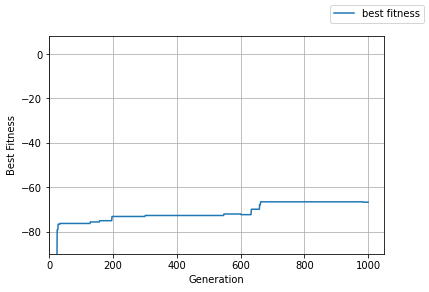

In [47]:
import matplotlib
import matplotlib.pyplot as plt

last_saved_checkpoint = 999

n_gens = np.arange(1,last_saved_checkpoint+2)

plt.plot(n_gens, fitness_list[:1000], label='best fitness')
# plt.plot(n_gens, wc_budget_constraint_list, label='wc-bc of most fit genome')

plt.ylabel('Best Fitness')
plt.xlabel('Generation')

axes = plt.gca()
axes.set_xlim([0  ,None])
axes.set_ylim([-90,8])
plt.figlegend(loc=1)
plt.grid()
plt.show()

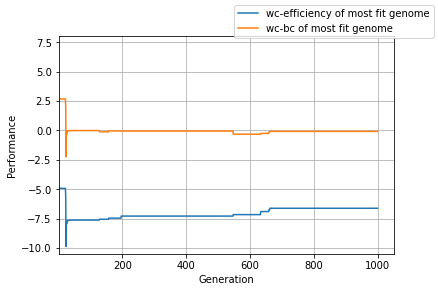

In [46]:
import matplotlib
import matplotlib.pyplot as plt

last_saved_checkpoint = 999

n_gens = np.arange(1,last_saved_checkpoint+2)

plt.plot(n_gens, wc_efficiency_list[:1000], label='wc-efficiency of most fit genome')
plt.plot(n_gens, wc_budget_constraint_list[:1000], label='wc-bc of most fit genome')

plt.ylabel('Performance')
plt.xlabel('Generation')

axes = plt.gca()
axes.set_xlim([1,None])
axes.set_ylim([None,8])
plt.figlegend(loc=1)
plt.grid()
plt.show()

In [ ]:
# analyse_neat_vcg(session_config_filename, n_agents, winner, most_fit_genomes)

In [ ]:
# best_genome = evolution_stats.best_genome()
# marker  = n_agents-1
# config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
#                          neat.DefaultSpeciesSet, neat.DefaultStagnation,
#                          session_config_filename)
# best_net = neat.nn.FeedForwardNetwork.create(best_genome, config)
# max_budget_constraint, max_efficiency_constraint, worst_case_efficiency = eval_single_genome(best_net, marker)
# penalty1 = 100*max_budget_constraint if max_budget_constraint>0 else 0 
# penalty2 = 100*max_efficiency_constraint if max_efficiency_constraint>0 else 0  
# best_fitness = min(worst_case_efficiency, upper_bound) - penalty1 - penalty2


In [ ]:
# print('max_budget_constraint: ', max_budget_constraint)
# print('max_efficiency_constraint: ', max_efficiency_constraint)
# print('worst_case_efficiency: ', worst_case_efficiency)
# print('best_fitness: ', best_fitness)